In [1]:
import math
import os
import time
import json

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
import torch.nn as nn
import matplotlib
from PIL import Image, ImageOps

import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

from segmentation_mask_overlay import overlay_masks

matplotlib.rcParams['figure.figsize'] = (20, 20)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [47]:
def visualize(image, ground_truth, prediction, mask_alpha=0.5):
    plt.imshow(image, cmap='seismic', interpolation='none')
    plt.imshow(ground_truth, cmap='RdYlGn', interpolation='none', alpha=mask_alpha)
    plt.imshow(prediction, cmap='PuOr', interpolation='none', alpha=mask_alpha)

In [43]:
def visualize(image, masks, masks_colours, mask_threshold=0.5, mask_alpha=0.5):
    """
    :param image: Оригинальное изображение
    :param masks: Список масок
    :param masks_colours: Список из matplotlib colormaps, где для каждой маски указана своя цветовая карта
    :param mask_threshold: Порог, фильтрации значений масок. Значения ниже порога заменяются на np.none
    :param mask_alpha: Степень прозрачности масок
    :return:
    """
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='seismic', interpolation='none')
    for i in range(len(masks)):
        mask = masks[i]
        mask = np.ma.masked_less(mask, mask_threshold)
        ax.imshow(mask, cmap=masks_colours[i], interpolation='none', alpha=mask_alpha)
    plt.show()

In [3]:
class FaultModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, encoder_weights, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=out_classes, **kwargs
        )
        self.in_channels = in_channels

        if in_channels == 3:
            # preprocessing parameteres for image
            params = smp.encoders.get_preprocessing_params(encoder_name)
            self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
            self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.save_hyperparameters()

    def forward(self, image):
        if self.in_channels == 3:
            # normalize image here
            image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["image"].float()
        # Shape of the image should be (batch_size, num_channels, height, width)
        assert image.ndim == 4
        # Check that image dimensions are divisible by 32
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"].float()
        # Shape of the mask should be [batch_size, num_classes, height, width]
        assert mask.ndim == 4
        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # Compute IoU metric
        # compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [4]:
class Dataset(BaseDataset):
    def __init__(self, data, data_path, augmentation=None, preprocessing=None):
        self.data = data
        self.data_path = data_path
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        record = self.data[i]
        image = np.expand_dims(cv2.imread(os.path.join(self.data_path, 'seis', record['data']), cv2.IMREAD_GRAYSCALE), axis=0)
        mask = np.expand_dims(cv2.imread(os.path.join(self.data_path, 'fault', record['label']), cv2.IMREAD_GRAYSCALE), axis=0) / 255

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return {"image":image, "mask": mask}

    def __len__(self):
        return len(self.data)

In [41]:
def predict_segment(network, data_base_path: str, segment_nums, device):

    def predict_given_image(model, loader, device):
        batch = next(iter(loader))
        with torch.no_grad():
            model.eval()
            logits = model(batch['image'].float().to(device))
        pr_masks = logits.sigmoid().cpu()
        for image, gt_mask, pr_mask in zip(batch['image'], batch['mask'], pr_masks):
            # visualize(image=image.numpy().squeeze(), ground_truth=gt_mask.numpy().squeeze(), prediction=pr_mask.numpy().squeeze())
            visualize(image=image.numpy().squeeze(), masks=[gt_mask.numpy().squeeze(), pr_mask.numpy().squeeze()], masks_colours=['winter', 'Wistia'])

    with open(os.path.join(data_base_path, 'metadata.json'), 'r') as file:
        metadata = json.load(file)
    for i in segment_nums:
        record = metadata[i]
        data_loader = DataLoader(Dataset([record], data_base_path), batch_size=1, shuffle=False)
        predict_given_image(network, data_loader, device)

In [6]:
efficent_net = FaultModel.load_from_checkpoint('deeplabv3_plus_logs/lightning_logs/version_0/checkpoints/epoch=99-step=36000.ckpt')
efficent_net.eval()
efficent_net.to(device);

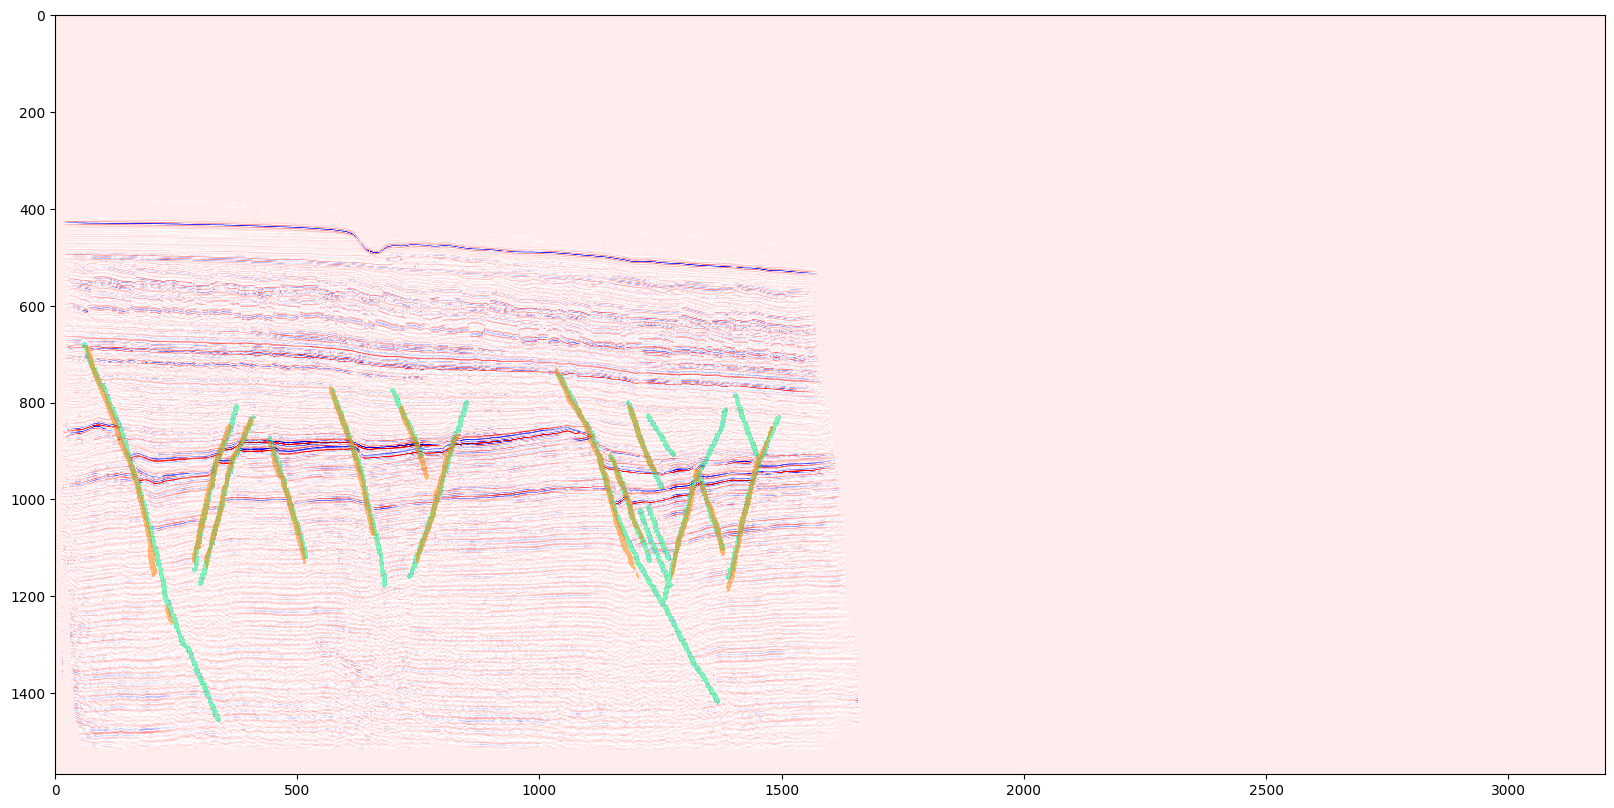

In [47]:
predict_segment(efficent_net, '../2d unet full data/data/complete/train', range(13, 55, 100), device)